In [ ]:
!apt-get install tesseract-ocr
!pip install pytesseract

Reading package lists... Done
Building dependency tree       
Reading state information... Done
tesseract-ocr is already the newest version (4.00~git2288-10f4998a-2).
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 49 not upgraded.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from sklearn.cluster import AgglomerativeClustering
from matplotlib import pyplot as plt
from pytesseract import Output
from tabulate import tabulate
import pandas as pd
import numpy as np
import pytesseract
import argparse
import imutils
import cv2

In [ ]:
args = {
	"output": "results.csv",
	"min_conf": 0,
	"dist_thresh": 25.0,
	"min_size": 2,
}

In [ ]:
# set a seed for our random number generator
np.random.seed(42)

In [ ]:
image = cv2.imread('Colo BT.jpeg')
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

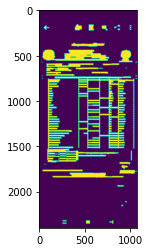

In [ ]:
kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (51, 11))
gray = cv2.GaussianBlur(gray, (3, 3), 0)
blackhat = cv2.morphologyEx(gray, cv2.MORPH_BLACKHAT, kernel)
grad = cv2.Sobel(blackhat, ddepth=cv2.CV_32F, dx=1, dy=0, ksize=-1)
grad = np.absolute(grad)
(minVal, maxVal) = (np.min(grad), np.max(grad))
grad = (grad - minVal) / (maxVal - minVal)
grad = (grad * 255).astype("uint8")
grad = cv2.morphologyEx(grad, cv2.MORPH_CLOSE, kernel)
thresh = cv2.threshold(grad, 0, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)[1]
thresh = cv2.dilate(thresh, None, iterations=3)
plt.imshow(thresh)

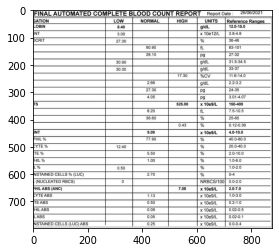

In [ ]:
cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
cnts = imutils.grab_contours(cnts)
tableCnt = max(cnts, key=cv2.contourArea)

(x, y, w, h) = cv2.boundingRect(tableCnt)
table = image[y:y + h, x:x + w]

# plt.imshow(image)
plt.imshow(table)

In [ ]:
options = "--psm 6"
results = pytesseract.image_to_data(table, config=options, output_type=Output.DICT)
print(results)

{'level': [1, 2, 3, 4, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 3, 4, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 3, 4, 5, 5, 5, 5, 4, 5, 5, 5, 4, 5, 3, 4, 5, 5, 4, 5, 4, 5, 5, 3, 4, 5, 5, 5, 5, 3, 4, 5, 5, 3, 4, 5, 5, 5, 5, 3, 4, 5, 5, 5, 5, 5, 5, 5], 'page_num': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], 'block_num': [0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], 'par_num': [0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 5, 5, 5, 5, 5, 5, 6, 6, 6, 6, 7, 7, 7, 7, 7, 7, 8, 8, 8, 8, 8, 8, 8, 8, 8], 'line_num': [0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 

In [ ]:
coords = []
ocrText = []

# loop over each of the individual text localizations
for i in range(0, len(results["text"])):
	# extract the bounding box coordinates of the text region from
	# the current result
	x = results["left"][i]
	y = results["top"][i]
	w = results["width"][i]
	h = results["height"][i]

	# extract the OCR text itself along with the confidence of the
	# text localization
	text = results["text"][i]
	conf = int(float(results["conf"][i]))

	# filter out weak confidence text localizations
	if conf > args["min_conf"]:
		# update our text bounding box coordinates and OCR'd text,
		# respectively
		coords.append((x, y, w, h))
		ocrText.append(text)

In [ ]:
# extract all x-coordinates from the text bounding boxes, setting the
# y-coordinate value to zero
xCoords = [(c[0], 0) for c in coords]

# apply hierarchical agglomerative clustering to the coordinates
clustering = AgglomerativeClustering(
	n_clusters=None,
	affinity="manhattan",
	linkage="complete",
	distance_threshold=args["dist_thresh"])
clustering.fit(xCoords)

AgglomerativeClustering(affinity='manhattan', distance_threshold=25.0,
                        linkage='complete', n_clusters=None)

In [ ]:
# initialize our list of sorted clusters
sortedClusters = []

# loop over all clusters
for l in np.unique(clustering.labels_):
	# extract the indexes for the coordinates belonging to the
	# current cluster
	idxs = np.where(clustering.labels_ == l)[0]

	# verify that the cluster is sufficiently large
	if len(idxs) > args["min_size"]:
		# compute the average x-coordinate value of the cluster and
		# update our clusters list with the current label and the
		# average x-coordinate
		avg = np.average([coords[i][0] for i in idxs])
		sortedClusters.append((l, avg))

# sort the clusters by their average x-coordinate and initialize our
# data frame
sortedClusters.sort(key=lambda x: x[1])
df = pd.DataFrame()

In [ ]:
# loop over the clusters again, this time in sorted order
for (l, _) in sortedClusters:
	# extract the indexes for the coordinates belonging to the
	# current cluster
	idxs = np.where(clustering.labels_ == l)[0]

	# extract the y-coordinates from the elements in the current
	# cluster, then sort them from top-to-bottom
	yCoords = [coords[i][1] for i in idxs]
	sortedIdxs = idxs[np.argsort(yCoords)]

	# generate a random color for the cluster
	color = np.random.randint(0, 255, size=(3,), dtype="int")
	color = [int(c) for c in color]

	# loop over the sorted indexes
	for i in sortedIdxs:
		# extract the text bounding box coordinates and draw the
		# bounding box surrounding the current element
		(x, y, w, h) = coords[i]
		cv2.rectangle(table, (x, y), (x + w, y + h), color, 2)

	# extract the OCR'd text for the current column, then construct
	# a data frame for the data where the first entry in our column
	# serves as the header
	cols = [ocrText[i].strip() for i in sortedIdxs]
	currentDF = pd.DataFrame({cols[0]: cols[1:]})

	# concatenate *original* data frame with the *current* data
	# frame (we do this to handle columns that may have a varying
	# number of rows)
	df = pd.concat([df, currentDF], axis=1)

In [ ]:
# replace NaN values with an empty string and then show a nicely
# formatted version of our multi-column OCR'd text
df.fillna("", inplace=True)
print(tabulate(df, headers="keys", tablefmt="psql"))

+----+------------+-------+---------+-------------+
|    | _          | tow   | BLOOD   | Reference   |
|----+------------+-------+---------+-------------|
|  0 | [          | [300  | NormAL  | se          |
|  1 | |          | [see  | [cera   | fares       |
|  2 | |          | a     | [ot     | 020         |
|  3 | |          | [oY   | ee      | 00-04       |
|  4 | |          | a     | [       |             |
|  5 | FINAL      | a     |         |             |
|  6 | GATION     | [ea   |         |             |
|  7 | nr         | [rns  |         |             |
|  8 | Tem        |       |         |             |
|  9 | nL         |       |         |             |
| 10 | (NUGLEATED |       |         |             |
| 11 | NSTAINED   |       |         |             |
+----+------------+-------+---------+-------------+


[INFO] saving CSV file to disk...


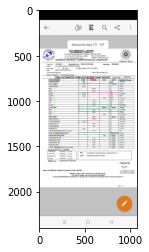

In [ ]:
# write our table to disk as a CSV file
print("[INFO] saving CSV file to disk...")
df.to_csv(args["output"], index=False)

# show the output image after performing multi-column OCR
plt.imshow(image)